# Importations

In [1]:
# from sklearnex import patch_sklearn
# patch_sklearn()

from src.utils import read_split_csv
from src.mlp.mlp import *
from src.mlp.mlp_plot import *
from src.mlp.scaling_uncertainty import *
import pandas as pd
import torch
print("Torch Version", torch.__version__)

Torch Version 1.11.0


In [2]:
torch.cuda.is_available()

True

if not, in shell : 

sudo rmmod nvidia_uvm && sudo modprobe nvidia_uvm

# Load data
(quadricoptere dataset)

In [3]:
datasets = read_split_csv("/App/Data/split_quad/")#, engine="python")
datasets["val"]

val.csv
train.csv


test.csv
lourd.csv


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
109923,2019-07-03 03:10:00,150,35.50,2.8,238.0,22.759777,23.505444,-79.782777,40.458953,365.169441,...,-0.076906,0.335496,-0.143232,-9.869870,12,0,100,R1,534.978656,537.998819
91658,2019-06-29 12:40:00,136,78.60,9.4,4.0,21.084534,26.065914,-79.782571,40.458586,290.375622,...,-0.082310,-1.529684,0.423300,-9.976319,8,250,25,R1,549.587645,526.000169
200354,2019-07-24 16:28:00,229,62.60,10.5,204.0,22.172565,18.448116,-79.782210,40.458218,315.845911,...,0.015051,-1.633767,0.061935,-9.457129,10,0,50,R1,409.042066,432.243997
122937,2019-07-03 16:35:00,162,3.10,0.9,265.0,21.716820,24.189297,-79.782738,40.458992,276.467557,...,-0.054514,0.133585,-0.133318,-10.589297,8,500,75,R1,525.314597,536.179872
164684,2019-07-15 08:05:00,195,112.60,2.2,128.0,23.306925,17.772215,-79.782766,40.459063,367.520864,...,0.018428,0.267958,-0.178819,-8.603159,8,250,100,R1,414.215676,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,2019-07-03 16:10:00,158,4.20,1.0,70.0,22.375399,21.795813,-79.782763,40.458980,270.231115,...,0.012899,0.072653,0.035458,-9.965531,12,250,75,R1,487.689996,544.146733
228319,2019-08-05 18:00:00,252,53.61,2.8,212.0,21.711811,26.304468,-79.781380,40.459499,345.136230,...,-0.000584,-0.393476,0.177744,-9.913366,12,500,75,R1,571.117643,586.617433
255344,2019-10-24 09:45:00,277,72.01,9.0,14.0,21.670494,21.390272,-79.782571,40.458526,293.235121,...,-0.107946,-0.764824,0.548552,-9.283231,10,500,25,R1,463.537766,460.171522


In [4]:
# remove columns 
cols_ignored = ["time_start","battery_voltage","battery_current", "altitude","speed","route", "position_x", "position_y", "flight"]
cols_redundent = ["linear_acceleration_x", "velocity_y", "power"]
target = ["power_smoothed"]

datasets_cleaned = dict()
for k in datasets.keys():
    datasets_cleaned[k] = datasets[k].drop(columns = cols_ignored + cols_redundent) # + target)

datasets_cleaned["val"]

,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,payload,power_smoothed
index,,,,,,,,,,,,,,,,,
109923,35.50,2.8,238.0,365.169441,0.019652,-0.009543,-0.892996,0.449534,-0.079833,3.000340,0.006295,0.028133,-0.076906,-0.143232,-9.869870,0,537.998819
91658,78.60,9.4,4.0,290.375622,-0.065850,-0.020889,0.102929,0.992287,-0.505729,0.908372,0.071907,0.034870,-0.082310,0.423300,-9.976319,250,526.000169
200354,62.60,10.5,204.0,315.845911,-0.020135,-0.081124,0.972382,0.217915,0.079185,1.620667,-0.015960,0.032285,0.015051,0.061935,-9.457129,0,432.243997
122937,3.10,0.9,265.0,276.467557,-0.029125,-0.007355,-0.769531,0.637903,-0.045260,0.282797,0.178007,0.083491,-0.054514,-0.133318,-10.589297,500,536.179872
164684,112.60,2.2,128.0,367.520864,0.002847,0.011134,0.129321,0.991536,0.140437,-1.149955,-0.005068,0.014159,0.018428,-0.178819,-8.603159,250,420.793236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119371,4.20,1.0,70.0,270.231115,-0.001946,-0.004951,-0.731368,0.681962,0.014317,0.171766,-0.027388,0.043483,0.012899,0.035458,-9.965531,250,544.146733
228319,53.61,2.8,212.0,345.136230,-0.028327,-0.122869,0.967072,0.221073,0.018804,1.762058,-0.044206,0.016506,-0.000584,0.177744,-9.913366,500,586.617433
255344,72.01,9.0,14.0,293.235121,-0.013434,-0.028738,0.109309,0.993502,-0.773985,-0.051941,0.131445,-0.257779,-0.107946,0.548552,-9.283231,500,460.171522


## Data scaling

Data scaling description:
* For the time feature `time` we perform a `zeromax` scaling using the maximum time over training set. 
* The flight number is not scaled
* The rest input features and the target are `standardized` (Z-scaling).

In [5]:
target = "power_smoothed"
input_features = list(datasets_cleaned["train"].columns)
input_features.remove(target)
print(input_features)



['time', 'wind_speed', 'wind_angle', 'position_z', 'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w', 'velocity_x', 'velocity_z', 'angular_x', 'angular_y', 'angular_z', 'linear_acceleration_y', 'linear_acceleration_z', 'payload']


In [6]:
# folder to store models and stats
model_dir = "/App/code preparation/baselines"

In [7]:
train_data = datasets_cleaned["train"]

# store stats computed on training data so we can use them for inference
means, stds = store_stats(train_data, model_dir)
# time max for max scaling
time_max = train_data.time.max()

In [8]:
data_all_norm = {}
for k in datasets_cleaned.keys():
    data_all_norm[k] = data_normalization(data=datasets_cleaned[k], means=means, stds=stds, time_max=time_max)

In [9]:
train_norm = data_normalization(data=train_data, means=means, stds=stds, time_max=time_max)

dev_in_data = datasets_cleaned["test"]
dev_in_norm = data_normalization(data=dev_in_data, means=means, stds=stds, time_max=time_max)

train_norm

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power_smoothed,velocity_x,velocity_z,wind_angle,wind_speed,time
index,,,,,,,,,,,,,,,,,
73245,0.655824,0.184456,-0.171442,0.333621,-4.967999,-0.880669,0.454052,0.229560,1.352152,0.007379,-1.346699,1.937011,0.561537,1.466609,0.990661,-0.880284,0.023432
16830,-0.035753,0.355712,-0.733666,1.984459,-0.154424,1.217911,-0.305529,-0.346488,0.159482,0.007379,-0.715804,0.138210,-1.024095,0.062553,2.582314,0.180172,0.442286
256306,1.364210,-0.172487,0.223178,-0.261906,0.527392,-1.034703,-0.635105,-2.314157,1.357951,1.221184,0.882617,1.563948,-0.931588,2.395572,1.687598,2.153799,0.179128
92785,-0.362237,0.290305,-0.719936,3.129304,1.658736,1.174823,-2.023530,-1.110646,0.226805,0.007379,1.767828,0.175483,0.576308,1.276056,2.883692,1.859228,0.349676
58106,0.224665,-0.375548,-0.120677,-0.895484,1.199466,-1.654210,0.603554,0.395324,-1.319698,-1.206427,-1.175607,0.635170,-0.609908,1.146379,1.094260,-0.320598,0.029560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86435,-0.041423,-0.038187,0.478742,1.055518,-0.185559,1.156269,-2.241585,-0.771591,0.277924,1.221184,0.130878,0.323648,-0.093198,1.162061,2.940201,2.006513,0.300288
257631,-0.409300,0.265893,-0.422280,0.583397,0.415668,1.227503,0.757584,0.283303,0.105737,-1.206427,-0.884261,-0.529817,0.318283,-0.728865,1.951304,-0.615170,0.350757
101588,-1.069225,0.185275,-0.708103,0.499390,0.429168,1.196028,-1.189949,-0.679506,0.213055,1.221184,0.163840,-0.452858,-0.443822,0.747192,-0.290195,1.122800,0.299603


In [10]:
train_norm.shape

(139006, 17)

In [11]:
train_ds = VPowerDataset(data=train_norm,
                         input_features=input_features,
                         target=target)
val_ds = VPowerDataset(data=dev_in_norm,
                       input_features=input_features,
                       target=target)
                       
train_ds.norm_df.describe()

,angular_x,angular_y,angular_z,linear_acceleration_y,linear_acceleration_z,orientation_w,orientation_x,orientation_y,orientation_z,payload,position_z,power_smoothed,velocity_x,velocity_z,wind_angle,wind_speed,time
count,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,1.390060e+05,139006.000000,1.390060e+05,139006.000000
mean,-8.996412e-18,2.351335e-18,-9.507572e-18,-1.302691e-16,-2.743744e-13,1.230208e-15,2.074286e-16,3.354230e-16,-1.335405e-17,8.505698e-17,-1.418450e-12,6.534155e-14,-7.906619e-16,4.610661e-16,1.197446,-5.784795e-16,0.279733
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.175498
min,-1.705390e+01,-1.827931e+01,-6.416585e+00,-8.249302e+00,-2.480568e+01,-1.755655e+00,-5.366546e+00,-5.284002e+00,-1.320697e+00,-1.206427e+00,-1.725689e+00,-5.691864e+00,-1.274268e+01,-2.632926e+00,-0.431466,-1.587254e+00,0.000000
25%,-4.833157e-01,-2.983924e-01,-3.574760e-01,-5.172347e-01,-3.308623e-01,-1.030616e+00,-3.681116e-01,-4.028865e-01,-8.575250e-01,-1.206427e+00,-7.838318e-01,-4.592195e-01,-3.999875e-01,-7.787637e-01,0.246634,-8.213693e-01,0.133742
50%,2.342631e-03,3.006872e-03,-1.164961e-01,-3.419829e-02,2.269205e-02,3.325118e-01,1.520386e-01,1.106615e-01,1.319233e-01,7.378572e-03,-3.517995e-02,2.676728e-02,1.807705e-01,-7.043224e-02,1.357966,-2.322271e-01,0.267844
75%,4.892355e-01,3.123176e-01,1.431176e-01,4.816354e-01,4.055403e-01,8.399744e-01,4.524366e-01,4.559519e-01,1.339351e+00,1.221184e+00,8.824814e-01,5.298406e-01,4.367156e-01,6.232662e-01,1.951304,6.514862e-01,0.406273
max,1.978503e+01,1.409486e+01,7.400811e+00,9.916518e+00,9.470536e+00,1.231334e+00,8.115451e+00,5.816320e+00,1.412163e+00,1.221184e+00,1.947681e+00,3.859987e+00,2.442699e+01,3.252586e+00,2.949619,3.715026e+00,1.000000


# Model Evaluation

This tutorial steps through the model evaluation process for the case of the baseline ensemble MC dropout.

## Get models and predictions


### Load models
We can load the models that we have trained before to evaluate them\
The provided baseline is an ensemble MC dropout consisting of 10 probabilistic MC dropout neural networks that have the same structure but trained with different parameters' initialization.


In [12]:
imin=1
imax=20
model_dir = "/App/code_preparation/baselines"

loaded_models = load_models(model_dir, imin, imax, input_features)
loaded_models

### Predictions et leur precision

During inference, each member of the ensemble is sampled 10 times (multi_runs=10) to capture the epistemic uncertainty due to the stochasticity of the single model’s parameters.

*predictions* = dictionnaire sur les datasets -> dictionnaire sur norm / denorm -> array de shape (100, nrows, 2) \
100 car on a 10 modèles qui donnent chacun 10 prédictions. Chaque prediction est une moyenne et une variance.

In [15]:
predictions = mul_predict(data_all_norm, input_features, loaded_models, means, stds, target="power_smoothed",multi_run=20)
predictions

100%|██████████| 20/20 [00:00<00:00, 42.79it/s]


{'val': {'norm': array([[[ 0.30685186,  0.05746887],
          [-0.13911319,  0.06735994],
          [-0.6318662 ,  0.04496787],
          ...,
          [-0.08628917,  0.11257729],
          [ 0.1430744 ,  0.3440462 ],
          [-0.29503214,  0.11229341]],
  
         [[ 0.30685186,  0.05746887],
          [ 0.08429587,  0.07410575],
          [-0.7449117 ,  0.09497951],
          ...,
          [-0.08622503,  0.11255877],
          [ 0.1430744 ,  0.3440462 ],
          [-0.29503214,  0.11229341]],
  
         [[ 0.30685186,  0.05746887],
          [-0.1337775 ,  0.06897259],
          [-0.84085035,  0.07618617],
          ...,
          [-0.08619785,  0.11255074],
          [ 0.1430744 ,  0.3440462 ],
          [-0.29503214,  0.11229341]],
  
         ...,
  
         [[ 0.27065063,  0.06867856],
          [-0.2141193 ,  0.13257012],
          [-0.5758678 ,  0.17155062],
          ...,
          [-0.13715789,  0.13943942],
          [-0.29415065,  0.11884215],
          [-0.33675334

In [16]:
uncertainties, sqr_errors = compute_error(predictions, datasets, "power_smoothed")
uncertainties

{'val': {'tvar': array([ 787.2243 ,  906.0523 ,  904.90454, ..., 1168.0607 , 2795.6328 ,
         1039.878  ], dtype=float32),
  'mvar': array([ 714.467  ,  860.3551 ,  761.7299 , ..., 1072.1239 , 2486.74   ,
          996.13135], dtype=float32),
  'varm': array([ 72.75731,  45.69718, 143.17462, ...,  95.93672, 308.89276,
          43.74674], dtype=float32),
  'epkl': array([4.8247375, 4.8595886, 4.9442596, ..., 5.000969 , 5.497345 ,
         4.925171 ], dtype=float32)},
 'train': {'tvar': array([2058.9888 ,  668.8388 , 2465.9487 , ..., 1080.7031 ,  404.67856,
          918.57043], dtype=float32),
  'mvar': array([1562.3494 ,  630.01086, 2068.3774 , ..., 1014.4533 ,  377.31458,
          871.14655], dtype=float32),
  'varm': array([496.63937 ,  38.827927, 397.57126 , ...,  66.24981 ,  27.363976,
          47.423874], dtype=float32),
  'epkl': array([5.6190186, 4.720871 , 5.5468445, ..., 4.9497833, 4.515167 ,
         4.8741837], dtype=float32)},
 'test': {'tvar': array([ 721.59985,  50

## Plots
### MSE retention values

In [17]:
print(sqr_errors.keys())
sets_names = ['val', 'test','lourd']

dict_keys(['val', 'train', 'test', 'lourd'])


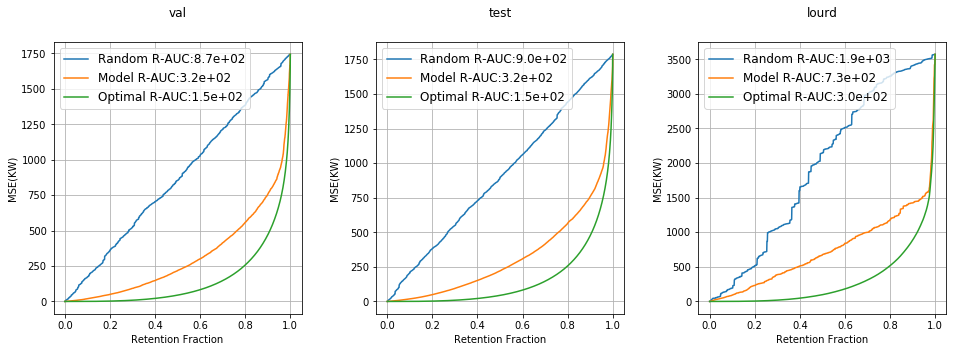

In [18]:
error_retention_plot_allsets(uncertainties, sqr_errors, sets_names)

### F1 retention curves

#### Define threshold of acceptable errors

In [19]:
# Use an acceptable error threshold of (500 kW)^2
thresh =  10** 2 # moitié de rmse dans le tableau plus bas, au carré

#### Plot F1 retentions

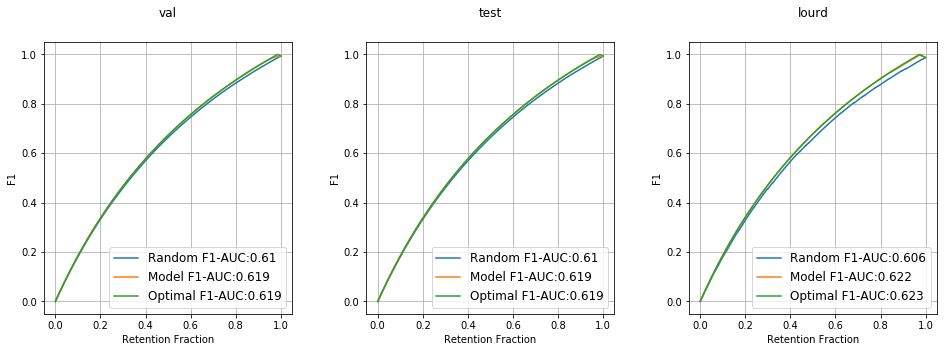

In [20]:
f1_retention_plot_allsets (uncertainties, sqr_errors, sets_names, thresh=20000)

## Predictive performance Tables

In [21]:
table_errors(predictions, datasets, target)

Classic metrics
╒════════╤══════════════════╤═════════════════╤══════════════╕
│ Data   │   RMSE Ens. (KW) │   MAE Ens. (KW) │     MAPE (%) │
╞════════╪══════════════════╪═════════════════╪══════════════╡
│ val    │               42 │              26 │ 27.55        │
├────────┼──────────────────┼─────────────────┼──────────────┤
│ train  │               41 │              26 │  1.23123e+15 │
├────────┼──────────────────┼─────────────────┼──────────────┤
│ test   │               42 │              26 │ 28.62        │
├────────┼──────────────────┼─────────────────┼──────────────┤
│ lourd  │               60 │              37 │ 58.74        │
╘════════╧══════════════════╧═════════════════╧══════════════╛


In [22]:
table_auc(sets_names, sqr_errors, uncertainties, thresh)

AUCs
╒════════╤═════════╤══════════╤═════════════╕
│ Data   │   R-AUC │   F1-AUC │   F1 @ 95 % │
╞════════╪═════════╪══════════╪═════════════╡
│ val    │ 316.714 │    0.442 │       0.489 │
├────────┼─────────┼──────────┼─────────────┤
│ test   │ 320.846 │    0.444 │       0.492 │
├────────┼─────────┼──────────┼─────────────┤
│ lourd  │ 734.692 │    0.258 │       0.358 │
╘════════╧═════════╧══════════╧═════════════╛


# Plot predictions

In [23]:
# quel est le vol le plus utilisé dans l'entrainement ?
datasets["train"].groupby("flight")["angular_x"].count().sort_values()

flight
187     450
235     463
14      469
98      473
111     476
       ... 
237    1031
126    1038
184    1040
210    1047
272    1337
Name: angular_x, Length: 195, dtype: int64

In [24]:
# retrouver les index des predictions + repasser à std au lieu de variance -> dans un df
pred_test = predictions["test"]["denorm"]
pred_test_moy = np.zeros([pred_test.shape[1], 2])
for i in range(pred_test.shape[1]):
    pred_test_moy[i,0] = np.mean(pred_test[:,i,0])
    pred_test_moy[i,1] = np.mean(np.sqrt(pred_test[:,i,1]))

pred_test_moy = pd.DataFrame(pred_test_moy, index=datasets["test"].index, columns=["mean", "std"]).sort_index()
pred_test_moy

,mean,std
index,,
118,230.728516,161.437500
123,196.064880,168.479401
124,188.360977,173.598984
132,431.206635,90.975899
134,470.722626,69.991333
...,...,...
257739,409.963776,61.093895
257744,298.524048,88.004120
257750,134.281403,113.519867


In [25]:
# pred_test_moy.to_csv("./baselines/predictions/pred.csv")

,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
250142,2019-09-19 10:29:00,272,0.00,0.5,319.0,24.522665,0.302167,-79.782830,40.459016,266.307265,...,-0.002794,0.574107,-0.132004,-9.794481,4,250,50,R6,7.409950,7.409950
250143,2019-09-19 10:29:00,272,0.20,0.5,321.0,24.361151,2.170834,-79.782830,40.459016,266.314653,...,-0.006558,0.583756,-0.126945,-9.801146,4,250,50,R6,52.884022,52.884022
250144,2019-09-19 10:29:00,272,0.30,0.5,325.0,24.505136,0.333975,-79.782830,40.459016,266.321527,...,0.012839,0.591600,-0.095437,-9.797760,4,250,50,R6,8.184091,8.184091
250145,2019-09-19 10:29:00,272,0.51,0.5,324.0,23.205507,19.155823,-79.782830,40.459016,266.321690,...,-0.007773,0.595155,-0.124009,-9.814390,4,250,50,R6,444.520584,444.520584
250146,2019-09-19 10:29:00,272,0.61,0.6,325.0,24.448793,1.574451,-79.782830,40.459015,266.328474,...,-0.007116,0.539788,-0.179882,-9.803894,4,250,50,R6,38.493432,38.493432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251988,2019-09-19 10:29:00,272,276.91,2.2,258.0,22.287754,4.516608,-79.782845,40.459000,265.814547,...,0.009623,0.308097,-0.109221,-9.826339,4,250,50,R6,100.665043,100.665043
251989,2019-09-19 10:29:00,272,277.10,2.3,260.0,22.300276,4.651788,-79.782845,40.459000,265.802198,...,-0.086934,0.229311,-0.132198,-9.766861,4,250,50,R6,103.736150,103.736150
251990,2019-09-19 10:29:00,272,277.20,2.3,266.0,22.304031,4.564318,-79.782845,40.459000,265.829081,...,0.040295,0.252551,-0.104589,-9.794949,4,250,50,R6,101.802696,101.802696


,time_start,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,route,power,power_smoothed
index,,,,,,,,,,,,,,,,,,,,,
250148,2019-09-19 10:29:00,272,0.90,0.8,329.0,24.523918,1.383609,-79.782830,40.459015,266.333118,...,0.006830,0.555986,-0.121363,-9.791325,4,250,50,R6,33.931506,33.931506
250150,2019-09-19 10:29:00,272,1.20,0.9,325.0,24.273506,5.057328,-79.782830,40.459015,266.338264,...,-0.001066,0.572722,-0.140163,-9.806115,4,250,50,R6,122.759088,122.759088
250153,2019-09-19 10:29:00,272,1.70,1.0,321.0,23.890379,11.649349,-79.782830,40.459015,266.345057,...,-0.042580,0.653410,-0.271956,-9.820437,4,250,50,R6,278.307367,289.819690
250154,2019-09-19 10:29:00,272,1.81,1.0,320.0,23.792719,13.176089,-79.782830,40.459015,266.348017,...,0.066030,0.623719,-0.158093,-9.847524,4,250,50,R6,313.494988,334.113624
250155,2019-09-19 10:29:00,272,2.00,1.0,316.0,23.591139,16.738483,-79.782830,40.459015,266.348865,...,0.041715,0.568773,-0.218040,-9.837639,4,250,50,R6,394.879887,373.209683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251974,2019-09-19 10:29:00,272,274.80,2.8,233.0,21.766901,15.410538,-79.782845,40.458999,265.989550,...,-0.045751,-0.070699,0.013964,-9.365030,4,250,50,R6,335.439649,359.948029
251975,2019-09-19 10:29:00,272,275.00,2.7,238.0,21.804462,14.321145,-79.782845,40.458999,265.920706,...,0.206530,-0.415217,0.850569,-10.121136,4,250,50,R6,312.264869,326.200891
251982,2019-09-19 10:29:00,272,276.00,2.7,246.0,22.382910,2.170834,-79.782845,40.458999,265.810252,...,0.017868,0.224247,-0.126995,-9.829260,4,250,50,R6,48.589588,50.909112


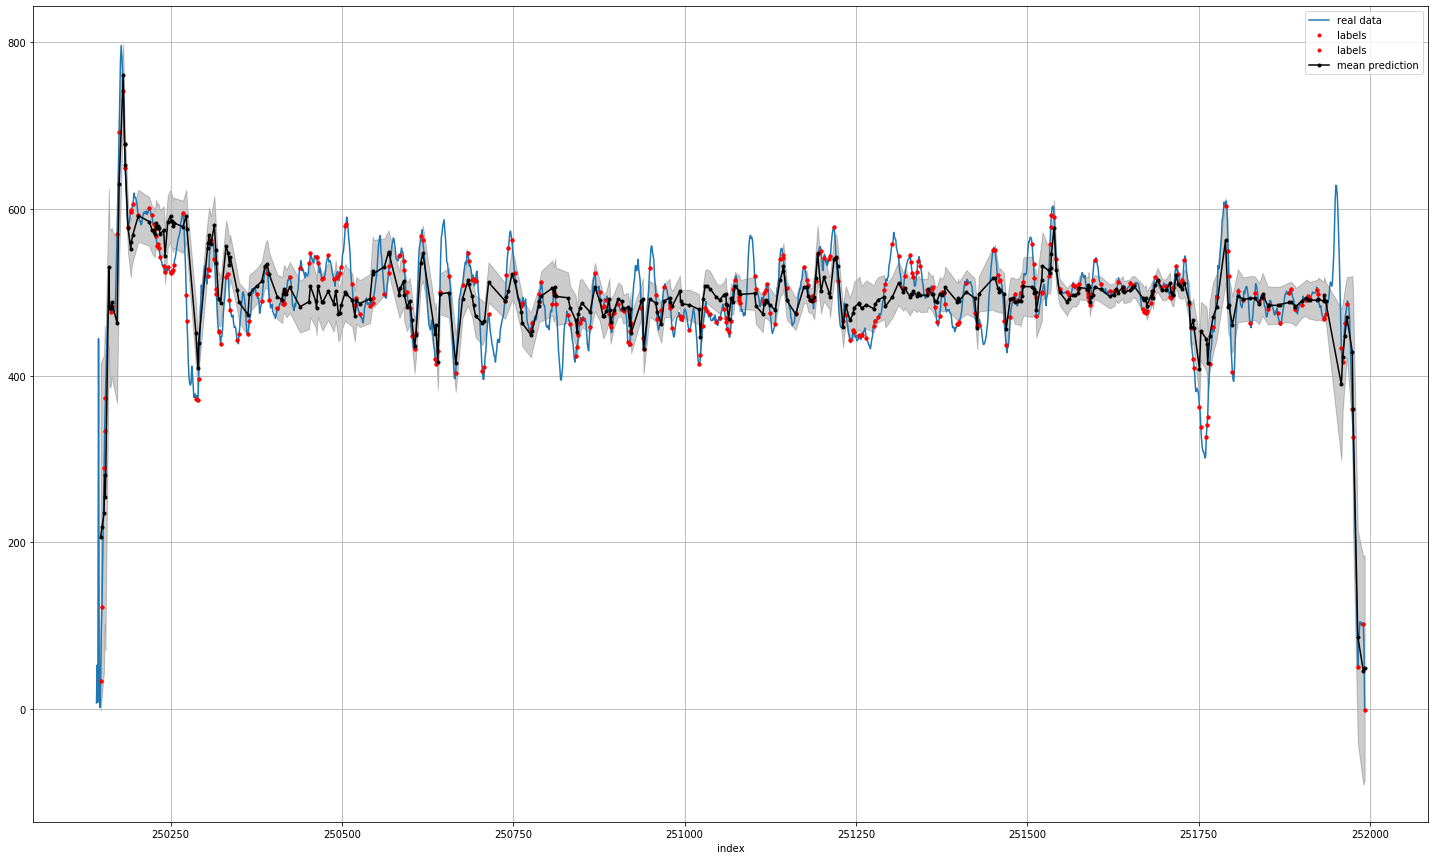

In [26]:
def plot_flight_pred(datasets, flight, pred_test_moy, test_name, target):
    """ Plot one flight and its predictions given by the model, as well as real data for those points """
    figsize=(25,15)
    # plot line for data of this flight
    dataset_complete = pd.concat([datasets[k] for k in datasets.keys()])
    dataset_complete.loc[dataset_complete.flight == flight, target].sort_index().plot(marker="", figsize=figsize, label="real data")
    display(dataset_complete.loc[dataset_complete.flight == flight].sort_index())
    # plot markers of test labels
    data_test = datasets[test_name]
    ex_test = data_test.loc[data_test.flight == flight].sort_index()
    display(ex_test)
    dataset_complete.loc[ex_test.index,target].plot(marker=".", figsize=figsize, ls='', label="labels", color="r")
    # ex_test["power"].plot(marker=".", figsize=figsize, ls='', label="labels", color="r")
    data_test.loc[data_test.flight==flight, target].sort_index().plot(marker=".", figsize=figsize, ls='', label="labels", color="r")
    # plot predictions with uncertainty
    yerr = pred_test_moy.loc[ex_test.index, "std"].sort_index()
    moy = pred_test_moy.loc[ex_test.index,"mean"].sort_index()
    moy.plot(marker=".", figsize=figsize, ls='-', label="mean prediction", color="black")
    plt.fill_between(ex_test.index, moy - yerr, moy + yerr, color="black", alpha=0.2)

    # plt.xlim(250250, 250600)
    plt.legend()
    plt.grid()
    plt.show()

plot_flight_pred(datasets, 272, pred_test_moy, "test", "power_smoothed")